In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import requests
import tensorflow as tf


In [18]:
# Load and preprocess the data
data = pd.read_csv('/content/drive/MyDrive/Truth seek/Features_For_Traditional_ML_Techniques.csv')
data = data.drop(columns=['Unnamed: 0', 'majority_target', 'statement', 'embeddings'])

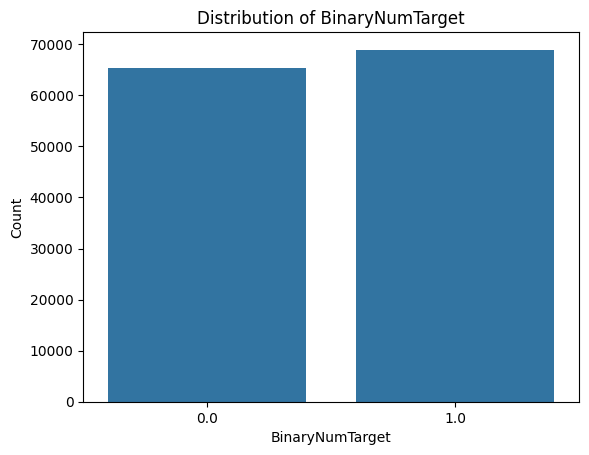

In [19]:
# Plot target variable distribution
sns.countplot(x='BinaryNumTarget', data=data)
plt.xlabel('BinaryNumTarget')
plt.ylabel('Count')
plt.title('Distribution of BinaryNumTarget')
plt.show()

In [20]:
data['BinaryNumTarget'].value_counts()

,count
BinaryNumTarget,
1.0,68930
0.0,65268


In [21]:
# Separate majority and minority classes
df_majority = data[data['BinaryNumTarget'] == 0]
df_minority = data[data['BinaryNumTarget'] == 1]

In [22]:
# If the minority class is larger than the majority class, swap them
if len(df_minority) > len(df_majority):
    df_majority, df_minority = df_minority, df_majority

In [23]:
from sklearn.utils import resample


In [24]:
# Undersample the majority class to the size of the minority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # sample without replacement
                                   n_samples=min(len(df_majority), len(df_minority)),  # use the size of the smaller class
                                   random_state=42)  # reproducible results

In [25]:
# Combine the downsampled majority class with the minority class
data = pd.concat([df_majority_downsampled, df_minority])

In [26]:
# Shuffle the dataset to mix the majority and minority classes
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

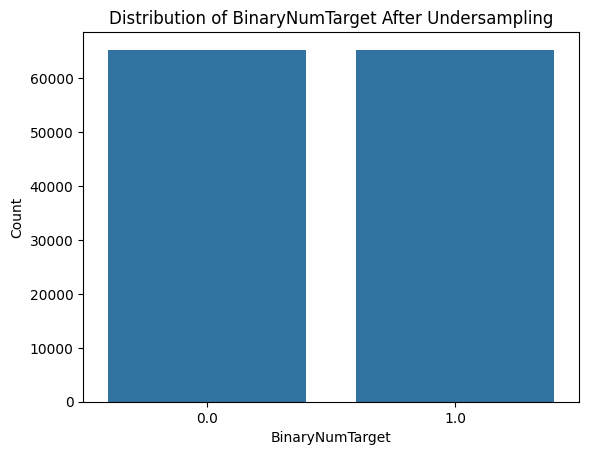

BinaryNumTarget
1.0    65268
0.0    65268
Name: count, dtype: int64


In [27]:
# Plot the new target variable distribution
sns.countplot(x='BinaryNumTarget', data=data)
plt.xlabel('BinaryNumTarget')
plt.ylabel('Count')
plt.title('Distribution of BinaryNumTarget After Undersampling')
plt.show()

# Check the distribution
print(data['BinaryNumTarget'].value_counts())

In [28]:
# Prepare tweet data for model
max_words = 1000  # Max number of words to keep in Tokenizer
max_seq_length = 100  # Max sequence length for padding


In [29]:
import re

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

data['tweet'] = data['tweet'].apply(clean_text)


In [30]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['tweet'])
sequences = tokenizer.texts_to_sequences(data['tweet'])
word_index = tokenizer.word_index

tweet_data = pad_sequences(sequences, maxlen=max_seq_length)

In [31]:
# Target variable
target = data['BinaryNumTarget'].values

In [32]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tweet_data, target, test_size=0.2, random_state=42)

In [33]:
# RNN Model Architecture
text_input = Input(shape=(max_seq_length,))
embedding_layer = Embedding(max_words, 100)(text_input)
lstm_layer = LSTM(64, return_sequences=False)(embedding_layer)
lstm_layer = Dropout(0.5)(lstm_layer)
dense_layer = Dense(64, activation='relu')(lstm_layer)
dense_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)

In [34]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)

In [35]:
model = Model(inputs=text_input, outputs=output_layer)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# Model Training
callbacks = [EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)]
history = model.fit(X_train, y_train, epochs=70, batch_size=32,
                    validation_split=0.2, callbacks=callbacks)


Epoch 1/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 198s 73ms/step - accuracy: 0.7559 - loss: 0.4681 - val_accuracy: 0.9204 - val_loss: 0.2136
Epoch 2/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 201s 73ms/step - accuracy: 0.9243 - loss: 0.2084 - val_accuracy: 0.9264 - val_loss: 0.1953
Epoch 3/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 195s 70ms/step - accuracy: 0.9326 - loss: 0.1895 - val_accuracy: 0.9223 - val_loss: 0.2029
Epoch 4/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 202s 70ms/step - accuracy: 0.9324 - loss: 0.1843 - val_accuracy: 0.9299 - val_loss: 0.1880
Epoch 5/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 189s 72ms/step - accuracy: 0.9335 - loss: 0.1811 - val_accuracy: 0.9267 - val_loss: 0.1918
Epoch 6/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 193s 74ms/step - accuracy: 0.9346 - loss: 0.1749 - val_accuracy: 0.9270 - val_loss: 0.1896
Epoch 7/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 195s 75ms/step - accuracy: 0.9345 - loss: 0.1739 - val_accuracy: 0.9306 - val_loss: 0.1835
Epoch 8/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 192s 71ms/step - accuracy: 

In [37]:
# Print validation accuracy for each epoch
val_accuracy = history.history['val_accuracy']
print("Validation Accuracy for each epoch:")
for epoch, accuracy in enumerate(val_accuracy, 1):
    print(f"Epoch {epoch}: {accuracy:.4f}")

# Print final validation accuracy
final_val_accuracy = val_accuracy[-1]
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy for each epoch:
Epoch 1: 0.9204
Epoch 2: 0.9264
Epoch 3: 0.9223
Epoch 4: 0.9299
Epoch 5: 0.9267
Epoch 6: 0.9270
Epoch 7: 0.9306
Epoch 8: 0.9316
Epoch 9: 0.9285
Epoch 10: 0.9333
Epoch 11: 0.9334
Epoch 12: 0.9337
Epoch 13: 0.9342
Epoch 14: 0.9335
Epoch 15: 0.9319
Epoch 16: 0.9350
Epoch 17: 0.9357
Epoch 18: 0.9345
Epoch 19: 0.9356
Epoch 20: 0.9352
Final Validation Accuracy: 0.9352
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9354 - loss: 0.1683
Test Accuracy: 93.42%


In [38]:
# Define the function to get relevant news URLs
def get_relevant_urls(tweet_text):
    api_key = '06cba0dcd3d84dc3bc34aac90e62ba89'  # Replace with your actual NewsAPI.org API key
    url = f'https://newsapi.org/v2/everything?q={tweet_text}&sortBy=relevancy&apiKey={api_key}'

    response = requests.get(url)
    response_data = response.json()

    try:
        articles = response_data['articles']
    except KeyError:
        print("Error: The 'articles' key was not found in the API response.")
        return []

    urls = [article.get('url', '') for article in articles]
    return urls

In [39]:
# Example for new texts
new_texts = [
  "Sri Lanka faces a crucial challenge as they head into the second Test against England on Thursday at Lord’s, a venue that has often served as an unlikely home away from home for the visiting side."
 ]

In [40]:
# Preprocess the new texts
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=max_seq_length)

In [41]:
# Get predictions and news URLs
new_predictions = model.predict(new_data)
predicted_classes = (new_predictions > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


In [42]:
for text, prediction in zip(new_texts, predicted_classes):
    print(f"Tweet: {text}")
    print(f"Prediction: {'Positive' if prediction == 1 else 'Negative'}")
    urls = get_relevant_urls(text)
    print(f"Relevant News URLs: {urls}")
    print()

Tweet: Sri Lanka faces a crucial challenge as they head into the second Test against England on Thursday at Lord’s, a venue that has often served as an unlikely home away from home for the visiting side.
Prediction: Negative
Relevant News URLs: []



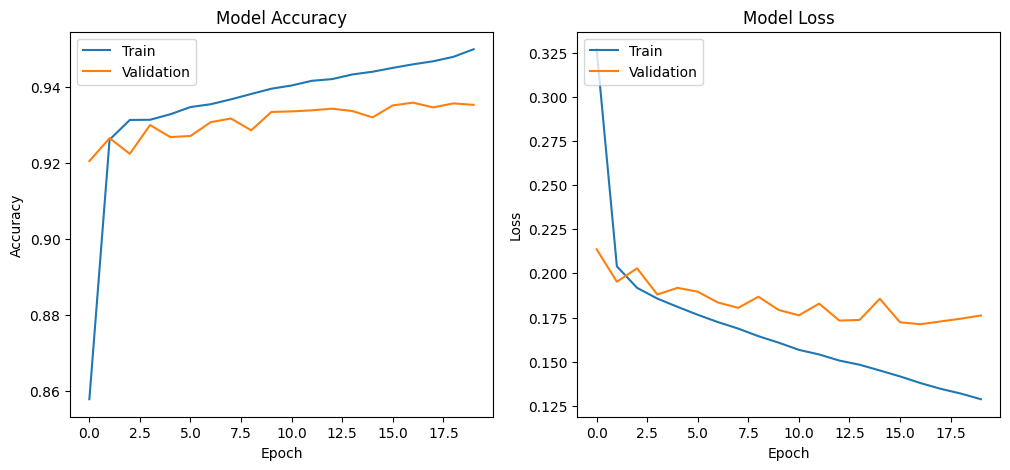

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step


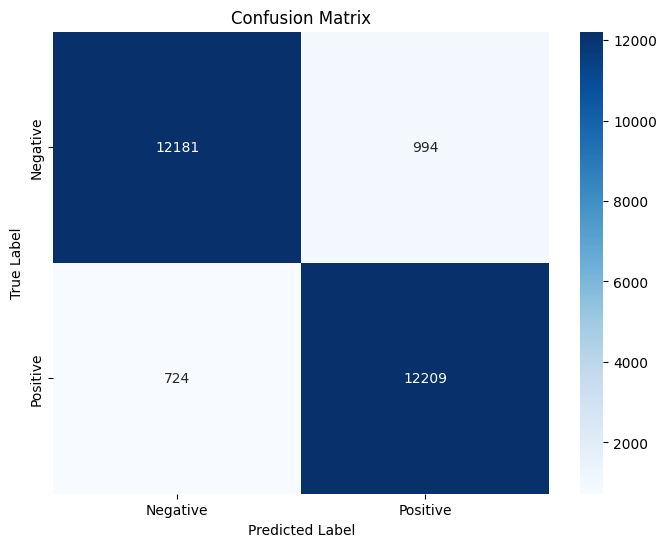

              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93     13175
    Positive       0.92      0.94      0.93     12933

    accuracy                           0.93     26108
   macro avg       0.93      0.93      0.93     26108
weighted avg       0.93      0.93      0.93     26108



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred_prob = model.predict(X_test)

# Step 2: Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 3: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print a classification report for detailed metrics
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


In [45]:
model.save('verity_function3.h5')


Re training process

In [46]:
from tensorflow.keras.models import load_model

# Load the saved model
model2 = load_model('/content/verity_function3.h5')


In [47]:
# Load dataset from a local CSV file
custom_data = pd.read_csv('/content/drive/MyDrive/Truth seek/Function3_data.csv')

# Display the first few rows to check if it's loaded correctly
custom_data.head()

,heading,content,label,Word count,Max word length,Min word length,Average word length,present_verbs,past_verbs,adjectives,...,PERSON,ORDINAL,TIME,NORP,FAC,WORK_OF_ART,MONEY,PERCENT,LAW,LANGUAGE
0,New largest dinosaur species found in Australi...,Scientists in Australia lack declassify a old ...,1,379.0,16.0,1.0,5.242744,47.0,0.0,40.0,...,5.405405,2.702703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SAITM issue: President to discuss with stakeho...,President Maithripala Sirisena disinherit summ...,1,117.0,20.0,1.0,5.683761,22.0,0.0,6.0,...,25.000000,NaN,12.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Intern’l responsibilities crucial for developm...,Norwegian Prime Minister Erna Solberg said tod...,1,251.0,16.0,1.0,5.840637,38.0,0.0,27.0,...,25.000000,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,Five remanded over assault on Sri Lankan HC,"Five people , who differ arrested for allegedl...",1,126.0,14.0,1.0,5.214286,17.0,0.0,6.0,...,17.391304,NaN,4.347826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Banners with LTTE chief's pic land duo in jail,Two nonmember of a fringe Tamil nationalist pa...,1,169.0,12.0,1.0,5.313609,23.0,0.0,11.0,...,25.000000,3.571429,NaN,3.571429,3.571429,NaN,NaN,NaN,NaN,NaN


In [48]:
# Ensure 'text' column contains strings
custom_data['content'] = custom_data['content'].astype(str)

# Replace NaN or missing values with empty strings
custom_data['content'] = custom_data['content'].fillna('')

In [49]:
# Clean and preprocess the data
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

custom_data['content'] = custom_data['content'].apply(clean_text)


In [50]:
# Separate data into '0' and '1' classes
data_00 = custom_data[custom_data['label'] == 0]
data_11 = custom_data[custom_data['label'] == 1]

In [51]:
from sklearn.utils import resample


In [52]:
#Randomly oversample the minority class to match the majority class
data_11_oversampled = resample(data_11,
                             replace=True,    # Sample with replacement
                            n_samples=len(data_00),  # Match number of majority class
                           random_state=42)  # For reproducibility

#Combine the majority class with the oversampled minority class
data_balanced1 = pd.concat([data_00, data_11_oversampled])

In [53]:
# Shuffle the combined dataset to mix the samples
data_balanced1 = data_balanced1.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
x_balanced1 = data_balanced1.drop(columns=['label'])
y_balanced1 = data_balanced1['label']

In [54]:
num_rows = x_balanced1.shape[0]
print(f'Number of rows: {num_rows}')

Number of rows: 1712


In [55]:
data_balanced1['label'].value_counts()

,count
label,
0,856
1,856


In [56]:
# Tokenizer and padding
tokenizer1 = Tokenizer(num_words=max_words)
tokenizer1.fit_on_texts(data_balanced1['content'])
sequences1 = tokenizer1.texts_to_sequences(data_balanced1['content'])
tweet_data1 = pad_sequences(sequences1, maxlen=max_seq_length)

# Target variable
target1 = y_balanced1.values

In [57]:
import pickle
with open('function3_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [58]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(tweet_data1, target1, test_size=0.2, random_state=42)


In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model (ensure it uses the same configuration as before)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])  # Change to a less suitable loss function

# Train the model with custom data
callbacks = [EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True)]
history2 = model2.fit(X_train1, y_train1, epochs=10, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.6202 - loss: 0.2554 - val_accuracy: 0.9234 - val_loss: 0.0740
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9051 - loss: 0.0713 - val_accuracy: 0.9562 - val_loss: 0.0355
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9630 - loss: 0.0323 - val_accuracy: 0.9781 - val_loss: 0.0166
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9858 - loss: 0.0139 - val_accuracy: 0.9854 - val_loss: 0.0114
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.9825 - loss: 0.0154 - val_accuracy: 0.9854 - val_loss: 0.0116
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9856 - loss: 0.0114 - val_accuracy: 0.9854 - val_loss: 0.0117


In [61]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model2.evaluate(X_test1, y_test1)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9690 - loss: 0.0250
Test Accuracy: 96.21%


In [62]:
# Make predictions on the test set
y_pred_prob1 = model2.predict(X_test1)
y_pred1 = (y_pred_prob1 > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test1, y_pred1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


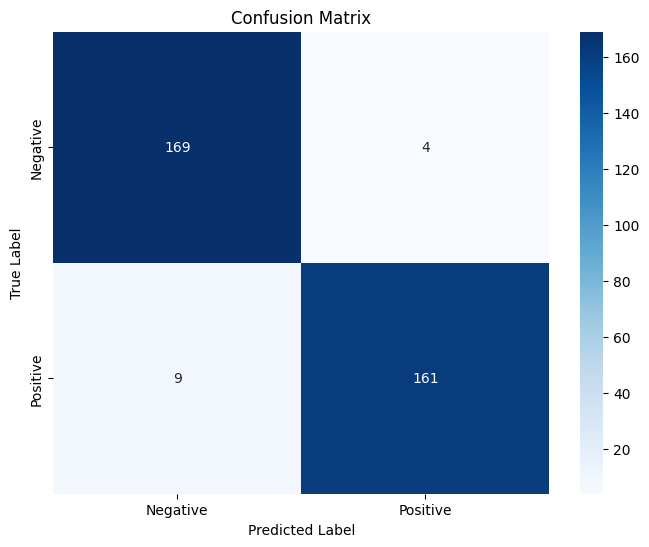

              precision    recall  f1-score   support

    Negative       0.95      0.98      0.96       173
    Positive       0.98      0.95      0.96       170

    accuracy                           0.96       343
   macro avg       0.96      0.96      0.96       343
weighted avg       0.96      0.96      0.96       343



In [63]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report
print(classification_report(y_test1, y_pred1, target_names=['Negative', 'Positive']))


In [64]:
# Save the retrained model
model2.save('verity_function3_retrained.h5')

In [65]:
from tensorflow.keras.models import load_model

# Load the saved retrained model
model_retrained = load_model('verity_function3_retrained.h5')


In [70]:
# Example new news article (replace this with the actual text)
new_article = "මොරගහකන්ද ජලාශයට ආසන්නව ගිරිතලේ - ඇළහැර අභයභූමියේ සැරිසරමින් සිටි ඇත් පැටවකු දඩයක්කරුවෙකුගේ වෙඩි පහර කිහිපයකින් මියගොස් ඇතැයි ඇළහැර වනජීවී කාර්යාලය සඳහන් කරයි"
new_article2 = "සිදුව අමන්දොළුව ප්‍රදේශයේ බෝඩිං කාමරයක සිටි කාන්තාවක තියුණු ආයුධයකින් පහරදී ඝාතනය කර ඇතැයි සීදූව පොලිසිය පවසයි."

In [74]:
# Clean the text using the same function
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

cleaned_article = clean_text(new_article2)

# Tokenize and pad the text using the tokenizer you fitted earlier
# Load the tokenizer if you saved it earlier
with open('function3_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Convert text to sequences
article_sequence = tokenizer.texts_to_sequences([cleaned_article])

# Pad the sequence to match the training input shape
padded_article = pad_sequences(article_sequence, maxlen=max_seq_length)


In [75]:
# Make prediction
prediction_prob = model_retrained.predict(padded_article)

# Convert probability to a binary prediction (1 or 0)
prediction = (prediction_prob > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [76]:
# Print the result
if prediction[0][0] == 1:
    print("The news is likely true (Positive).")
else:
    print("The news is likely false (Negative).")


The news is likely false (Negative).
